In [82]:
import pandas as pd
import requests
import numpy as np

In [83]:
api_key_EIA = 'your_api_key_here'  # Replace with your actual API key

url = f"https://api.eia.gov/v2/co2-emissions/co2-emissions-aggregates/data/?frequency=annual&data[0]=value&facets[sectorId][]=EC&start=1990&end=1996&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000&api_key={api_key_EIA}"

data_all = []
# Maximum length of EIA API output is 5000 rows; while loop below gets all rows
while True:
    response = requests.get(url)
    
    # Print status code for debugging
    print(f"Status Code: {response.status_code}")
    
    # If there's an error, print the full response
    if response.status_code == 200:
        print("Request successful")
    else:
        print(f"Request failed with status code: {response.status_code}")
        break
    
    data = response.json()
    
    if "response" not in data or "data" not in data["response"]:
        print("Unexpected response structure:", data)
        break
    
    data_all.extend(data["response"]["data"])
    
    if len(data["response"]["data"]) < 5000:
        break
    
    data['offset'] += 5000

states_total = pd.DataFrame(data_all)
print(len(states_total))

Status Code: 200
Request successful
1456


In [84]:
# drop unnecessary columns and rows for 'US', 'AK', 'HI':
states_total = states_total.loc[states_total['fuelId']=='TO']

states_total = states_total[['period', 'stateId', 'value']]

states_total = states_total.drop(states_total[states_total['stateId'].isin(['US', 'AK', 'HI'])].index)

In [85]:
# rename columns
states_total = states_total.rename(columns={'period': 'year', 'stateId': 'state', 'value': 'total_co2'})

In [86]:
states_total['total_co2'] = states_total['total_co2'].astype(float)*1000000

In [87]:
states_total

,year,state,total_co2
1,1996,WY,40630558.0
5,1996,WI,39691630.0
9,1996,WV,78739642.0
13,1996,WA,10737829.0
17,1996,VA,33564559.0
...,...,...,...
1439,1990,VA,23438072.0
1443,1990,WA,7532108.0
1447,1990,WV,71001562.0
1451,1990,WI,33198849.0


The EIA data on emissions give us yearly data. We will estimate monthly emissions using monthly data on emissions from the 1996-2024 data. We will construct these monthly weights by decomposing monthly power production data using the `seasonal_decompose` function from the `statsmodels` package. 

In [88]:
# Load monthly emissions data for 1996-2024
monthly_emissions_1996_2024 = pd.read_csv("/Users/nicholasgeiser/Documents/Erdos/monthly-emissions-1996-2024-final.csv", index_col=[0])

In [89]:
# Drop rows containing data for Alaska, Hawaii, and Puerto Rico
monthly_emissions_1996_2024 = monthly_emissions_1996_2024.drop(monthly_emissions_1996_2024.loc[monthly_emissions_1996_2024['State'].isin(['AK','HI','PR'])].index)

In [90]:
monthly_emissions_total = monthly_emissions_1996_2024.groupby('date')['total_co2'].sum()

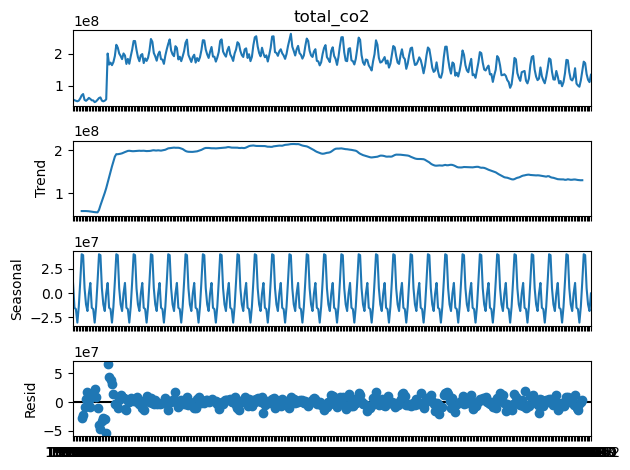

In [91]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
decomposition = seasonal_decompose(monthly_emissions_total, model='additive', period=12)
decomposition.plot()
plt.show()

In [92]:
seasonal_adjustment = pd.DataFrame({"Date":decomposition.seasonal.index, "Seasonal adjustment":decomposition.seasonal.values})

In [93]:
seasonal_adjustment['Date'] = pd.to_datetime(seasonal_adjustment['Date'])

In [94]:
seasonal_adjustment['Month'] = seasonal_adjustment['Date'].dt.month

In [95]:
seasonal_weights = seasonal_adjustment.groupby('Month')['Seasonal adjustment'].mean()

In [96]:
# Create a new month column using a cross-join
months = pd.DataFrame({'month': range(1,13)})
states_total = states_total.merge(months, how='cross')

In [97]:
seasonal_weights

Month
1     1.043445e+07
2    -1.502786e+07
3    -1.648156e+07
4    -3.029280e+07
5    -1.378080e+07
6     1.172323e+07
7     3.986228e+07
8     3.890280e+07
9     5.029696e+06
10   -1.162407e+07
11   -1.839507e+07
12   -3.503041e+05
Name: Seasonal adjustment, dtype: float64

We now construct monthly emissions for each state-year pair by multiplying the total level of CO2 by a dictionary of weights and dividing by the sum of weights to ensure that monthly emissions for each state-year pair sum to the total amount: